# Exercise 2: Kids First Data

## Learning Objectives and Key Concepts

Workshop attendees will learn how to query FHIR resources in various ways, to enable visualizing and analyzing data.  

What will participants do as part of the exercise?

 - Connecting to Kids First
 - Fetching and Examining Demographic Data
 - Finding a ResearchStudy
 - Fetching Patients enrolled in a ResearchStudy
 - Dealing with Extensions (e.g., age of onset)
 - Identifying Patients with desired diagnosis and data elements across multiple studies/datasets
 - Utilize APIs to explore the data (e.g., demographics)
 - Utilize APIs for research analyses (e.g., phenotype analysis)
 - Building Graphs from FHIR data
     - Demographics
     - Most Frequent Diagnoses
     - Age at Diagnosis
     - Overall Survival
     
     
 ### Icons in this Guide
 📘 A link to a useful external reference related to the section the icon appears in  

 🖐 A hands-on section where you will code something or interact with the server  

## Scenario

In this exercise we're going to explore how to access the data needed to generate the summary information from the Kids First dashboard in a few different ways. A snapshot of the Kids First dashboard is shown below:

![KF Dashboard](img/kf_dashboard.png)

The Kids First Data Portal is accessible at https://portal.kidsfirstdrc.org/explore (login required, though signup is free with any Google account)

For this exercise we'll be focusing on the following 4 graphs:
 - Demographics
 - Most frequent diagnoses
 - Age at diagnosis
 - Overall survival
 
 (Note that the image shown depicts the statistics for the entire Kids First population, whereas all graphs in this exercise will be based on specific sub-cohorts of the population, so the graphs we generate today will look a little different.)

## Environment Setup

First, let's configure the environment with the libraries and settings that will be used throughtout the rest of the exercise. (This cell has no output)

In [1]:
import json
import requests
import pandas as pd 
import numpy as np
import seaborn as sns

from datetime import datetime
import pprint

pprint = pprint.PrettyPrinter(indent=1).pprint
# pprint() is now available to pretty-print any JSON

FHIR_SERVER = 'https://kf-api-fhir-service.kidsfirstdrc.org'

# Kids First uses cookie-based authentication, so we've pre-fetched a cookie and made it available here.

# We make a requests.Session to ensure consistent headers/cookie across all the requests we make
s = requests.Session()
s.headers.update({'Accept': 'application/fhir+json'})

with open('kf_cookie.txt', 'r') as file:
    cookie = file.read().rstrip()
    s.cookies['AWSELBAuthSessionCookie-0'] = cookie

# disable SSL verification:
# these 2 lines should be commented out unless you actually see certificate errors
s.verify = False
requests.packages.urllib3.disable_warnings()


# This helper method allows us to easily switch between printing an entire Bundle, or just the first 20 lines.
# Set truncate_for_github = False for actual use,
# or just replace the function with a `return bundle`

def print_bundle(bundle, truncate_for_github = True):
    if not truncate_for_github:
        return bundle
    
    lines = json.dumps(bundle, indent=2).split('\n')
    if len(lines) <= 20:
        return bundle
    else:   
        print('\n'.join(lines[:20]))
        print('...\nBundle truncated. Change the "print_bundle" function above to print the full content.')

## 1. Demographics

Our first step will be show how to review basic demographic information for a patient cohort. Let's explore a few approaches for constructing a patient cohort.

### 1.1. Just the first N patients on the server

For the simplest example, let's just query for the first set of Patients on the server and see what that looks like.

🖐 Knowledge Check: Fill in the query to select Patients on the server.

(Note that there are over 10,000 Patient resources on this server, so we don't want to query them all or follow all the pagination. For performance reasons, all the examples in this notebook are intended to run with only a single page of results, but in a real-world use case, you would want to follow the pagination as shown in the previous exercise, to make sure you fetched all the requested data for a given query.)

In [2]:
r = s.get(f"{FHIR_SERVER}/Patient")
bundle = r.json()
print_bundle(bundle)

{
  "resourceType": "Bundle",
  "id": "7a69809f-f4e7-4ffe-9569-a3d64644cbec",
  "meta": {
    "lastUpdated": "2022-01-27T18:57:31.067+00:00"
  },
  "type": "searchset",
  "link": [
    {
      "relation": "self",
      "url": "https://kf-api-fhir-service.kidsfirstdrc.org/Patient"
    },
    {
      "relation": "next",
      "url": "https://kf-api-fhir-service.kidsfirstdrc.org?_getpages=7a69809f-f4e7-4ffe-9569-a3d64644cbec&_getpagesoffset=50&_count=50&_pretty=true&_bundletype=searchset"
    }
  ],
  "entry": [
    {
      "fullUrl": "https://kf-api-fhir-service.kidsfirstdrc.org/Patient/103070",
...
Bundle truncated. Change the "print_bundle" function above to print the full content.


There's a ton of data there, so we know the request was successful, but there's too much content to really get any sense of what we're looking at.  
(Note: if you get a `JSONDecodeError: Expecting value: line 1 column 1 (char 0)` then the cookie you are using expired - let the instructors know ASAP so they can fetch a new one, or [see these instructions to fetch a cookie](https://github.com/kids-first/kf-api-fhir-service#authenticate-to-access-server-environment) and put it into the kf_cookie.txt file, then reload the Environment Setup step above.)

Let's filter the bundle down to just a list of Patient resources, and see some examples of what Patient resources contain on this server:

In [3]:
patients = list(map(lambda e: e['resource'], bundle['entry']))
pprint(patients[0])
print('---')
pprint(patients[1])


{'extension': [{'extension': [{'url': 'text', 'valueString': 'Not Reported'}],
                'url': 'http://hl7.org/fhir/us/core/StructureDefinition/us-core-race'},
               {'extension': [{'url': 'text', 'valueString': 'Not Reported'}],
                'url': 'http://hl7.org/fhir/us/core/StructureDefinition/us-core-ethnicity'}],
 'gender': 'male',
 'id': '103070',
 'identifier': [{'value': '2-4F'},
                {'system': 'https://kf-api-dataservice.kidsfirstdrc.org/participants/',
                 'value': 'PT_803DN7MS'},
                {'system': 'urn:kids-first:unique-string',
                 'value': 'Patient-SD_0TYVY1TW-PT_803DN7MS'}],
 'meta': {'lastUpdated': '2021-11-16T09:49:02.048+00:00',
          'profile': ['http://hl7.org/fhir/StructureDefinition/Patient'],
          'source': '#yOJAbnQcyXm5DGen',
          'tag': [{'code': 'SD_0TYVY1TW'}],
          'versionId': '2'},
 'resourceType': 'Patient'}
---
{'extension': [{'extension': [{'url': 'text', 'valueString'

We can see the key data items we are looking for in these 2 Patient resources - gender, race, and ethnicity. (Race and ethnicity may be shown as "Not Reported" unfortunately, but we can see where they would fit)

Let's convert the list of Patients to a DataFrame and translate columns as appropriate.

In [4]:
patients_df = pd.DataFrame(patients)
patients_df.head()

,resourceType,id,meta,extension,identifier,gender,_birthDate
0,Patient,103070,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '2-4F'}, {'system': 'https://kf-api...",male,NaN
1,Patient,103310,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '46008'}, {'system': 'https://kf-ap...",male,NaN
2,Patient,103462,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '45251'}, {'system': 'https://kf-ap...",female,NaN
3,Patient,103443,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '4-15M'}, {'system': 'https://kf-ap...",female,NaN
4,Patient,103494,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '445'}, {'system': 'https://kf-api-...",male,NaN


Gender is a column all by itself, so it's easy to review.

Let's take a look at the gender breakdown with a pie chart.

<AxesSubplot:ylabel='gender'>

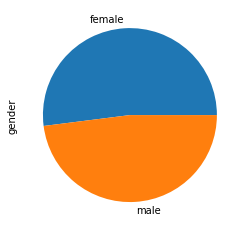

In [5]:
patients_df['gender'].value_counts().plot.pie()

Race and Ethnicity are a little tricker to because, as we saw in our examples above, they are recorded as _extensions_. Extensions are used to represent information that is not part of the basic definition of a resource.

Every element in a resource or data type includes an optional "extension" child element that may be present any number of times. Extensions contain a defining `url` and either a `value[x]` or sub-extensions (but not both). 

This also leads into choice types, ie, that `value[x]`. Choice types allow for different instances to use different data types as appropriate. Only one of the choices is allowed at a time on a given resource instance.

A simple example of choice types is the `Patient.deceased[x]` field indicating if the individual is deceased or not. `deceased[x]` is allowed to be either a `boolean` or `dateTime`.


Note that extensions are also allowed on primitive types, so in JSON these are represented by prepending the field name with an underscore `_` to create a new object-type field where the extension field can be added. The following example demonstrates the "birthTime" extension on the `Patient.birthDate` field:

```
{
    "resourceType": "Patient",
    ...
    "birthDate": "1987-06-05",
    "_birthDate": {
        "extension": [
            {
                "url": "http://hl7.org/fhir/StructureDefinition/patient-birthTime",
                "valueDateTime": "1987-06-05T04:32:01Z"
            }
        ]
    }
}
```

We'll see more instances like this later in the exercise.

📘[Read more about Extensions in FHIR](https://www.hl7.org/fhir/extensibility.html)


Getting back to Race and Ethnicity, these extensions are defined within [US Core](https://www.hl7.org/fhir/us/core/) which is an implementation guide that defines the base set of requirements for FHIR implementation in the US and reflects the ONC U.S. Core Data for Interoperability required data fields. Further details about US Core are outside the scope of this exercise, but for now understand that nearly all FHIR data within the US will use US Core.

Both the Race and Ethnicity extension use subextensions to represent the concept in 3 possible ways:
 - OMB Category, based on the (https://www.govinfo.gov/content/pkg/FR-1997-10-30/pdf/97-28653.pdf)
    - `url` is "ombCategory"
    - `valueCoding` from the [OMB Race Categories ValueSet](https://hl7.org/fhir/us/core/STU4/ValueSet-omb-race-category.html) or [OMB Ethnicity Categories ValueSet](https://www.hl7.org/fhir/us/core/ValueSet-omb-ethnicity-category.html)
 - Detailed, based on CDC Race and Ethnicity codes
   - `url` is "detailed"
   - `valueCoding` from the [Detailed race ValueSet](https://www.hl7.org/fhir/us/core/ValueSet-detailed-race.html) or [Detailed ethnicity ValueSet](https://www.hl7.org/fhir/us/core/ValueSet-detailed-ethnicity.html)
 - Text, free text (required)
   - `url` is "text"
   - `valueString` is free text

📘[Read more about the US Core Race Extension](https://hl7.org/fhir/us/core/STU4/StructureDefinition-us-core-race.html) 

📘[Read more about the US Core Ethnicity Extension](https://hl7.org/fhir/us/core/STU4/StructureDefinition-us-core-ethnicity.html) 

Given the above let's define functions to find the Race and Ethnicity on a Patient resource.

🖐 Fill in the contents of the `get_race` and `get_ethnicity` functions to fetch a consistent race and ethnicity value out of the extensions on a Patient resource:

In [6]:
def get_us_core_extension_value(key, extensions):
    url = f"http://hl7.org/fhir/us/core/StructureDefinition/us-core-{key}"
    extension = next(filter(lambda e: e['url'] == url, extensions), None)
    if extension is None:
        return None
    
    extension = extension['extension'][0]
    
    if 'valueString' in extension:
        return extension['valueString']
    elif 'valueCoding' in extension:
        return extension['valueCoding']['display']
    
    return None

def get_race(extensions):
    return get_us_core_extension_value('race', extensions)
    
def get_ethnicity(extensions):
    return get_us_core_extension_value('ethnicity', extensions)

And then we'll use those functions to get Race and Ethnicity as columns in our DataFrame:

In [7]:
patients_df['race'] = patients_df['extension'].map(lambda e: get_race(e))
patients_df['ethnicity'] = patients_df['extension'].map(lambda e: get_ethnicity(e))

patients_df.head()

,resourceType,id,meta,extension,identifier,gender,_birthDate,race,ethnicity
0,Patient,103070,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '2-4F'}, {'system': 'https://kf-api...",male,NaN,Not Reported,Not Reported
1,Patient,103310,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '46008'}, {'system': 'https://kf-ap...",male,NaN,White,Not Hispanic or Latino
2,Patient,103462,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '45251'}, {'system': 'https://kf-ap...",female,NaN,White,Not Hispanic or Latino
3,Patient,103443,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '4-15M'}, {'system': 'https://kf-ap...",female,NaN,White,Not Hispanic or Latino
4,Patient,103494,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '445'}, {'system': 'https://kf-api-...",male,NaN,White,Not Hispanic or Latino


Now let's review the race and ethnicity breakdown of this set of Patients:

<AxesSubplot:ylabel='race'>

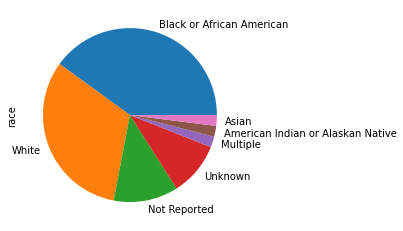

In [8]:
patients_df['race'].value_counts().plot.pie()

<AxesSubplot:ylabel='ethnicity'>

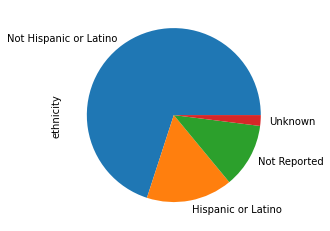

In [9]:
patients_df['ethnicity'].value_counts().plot.pie()

### 1.2. Patients with a given Condition

In the previous steps we reviewed what is essentially a random set of Patients, just the first set that the server returned when we asked for all Patients. Now let's get more targeted and query for just patients who have a diagnosis of a particular Condition. Then we can use the same process and functions we've already defined to analyze/visualize it.


Kids First uses the [Mondo Disease Ontology](https://mondo.monarchinitiative.org/) for describing Conditions. Other servers may use different one or code systems such as [SNOMED-CT](), [ICD-10](), or others. A simple browser for finding Mondo codes by description is available at https://www.ebi.ac.uk/ols/ontologies/mondo . Using this browser, we can look at a few sample codes:


| code | description |
| --- | --- |
| MONDO:0005015 | diabetes mellitus |
| MONDO:0005961 | sinusitis |
| MONDO:0008903 | lung cancer |
| MONDO:0021640 | grade III glioma |


Let's use grade III glioma as our condition of interest, with **MONDO:0021640** as our code of interest going forward.

In Exercise 1 we saw an instance of basic querying, when we searched for MedicationRequests associated to a given Patient. (Reminder: `"{FHIR_SERVER}/MedicationRequest?patient=10098"`) This is one of the most basic and fundamental types of query, where we get resources from a server, filtered by some aspect of the resource itself. In the previous example with medications, the MedicationRequest resource has a reference back to the Patient in the `patient` field so we can query that directly. 
But what if we want to go in the other direction? For example, find all Patients that are taking a given Medication, or Patients that have been diagnosed with a given Condition? 

Enter "chaining" and "reverse chaining". These are capabilities of FHIR that allow for more complex queries that can save a client and/or server from having to perform a series of operations.

The FHIR documentation offers the following examples of chaining:

>  In order to save a client from performing a series of search operations, reference parameters may be "chained" by appending them with a period (.) followed by the name of a search parameter defined for the target resource. This can be done recursively, following a logical path through a graph of related resources, separated by `.`. For instance, given that the resource `DiagnosticReport` has a search parameter named `subject`, which is usually a reference to a `Patient` resource, and the `Patient` resource includes a parameter `name` which searches on patient name, then the search  
> 
> `GET [base]/DiagnosticReport?subject.name=peter`  
>
> is a request to return all the lab reports that have a `subject` whose `name` includes "peter". Because the Diagnostic Report subject can be one of a set of different resources, it's necessary to limit the search to a particular type:  
>
> `GET [base]/DiagnosticReport?subject:Patient.name=peter`  
>
> This request returns all the lab reports that have a subject which is a patient, whose name includes "peter". 



In the case of "Patients diagnosed with a given Condition", we want the opposite direction - search for resources based on what links back to them. This is done with the `_has` search parameter.

The `_has` search parameter uses the colon character `:` to separate fields, and requires a few sub-parameters:

 - the resource type to search for references back from
 - the field on that resource which would link back to the current resource
 - a field on that resource to filter by


A complete example is:

`[base]/Patient?_has:Observation:patient:code=1234-5`

This requests the server to return Patient resources, where the patient resource is referred to by at least one Observation where the observation has a code of 1234, and where the Observation refers to the patient resource in the patient search parameter. 


Unfortunately we acknowledge the syntax is a little confusing. It may be easiest to read this query as as "Get Patients that have an Observation that links back to this Patient having a code of 1234-5"


📘 [Read more about FHIR Search Chaining and Reverse Chaining](https://hl7.org/fhir/r4/search.html#chaining)

Let's use this approach to find Patients based on a diagnosis.

🖐 Fill in the search query to find Patients that have a Condition of grade III glioma.

Then we'll use the same functions we defined before to map race and ethnicity columns and put the data into graphs.

In [10]:
r = s.get(f"{FHIR_SERVER}/Patient?_has:Condition:patient:code=MONDO:0021640")
bundle = r.json()
patients = list(map(lambda e: e['resource'], bundle['entry']))
patients_df = pd.DataFrame(patients)

patients_df['race'] = patients_df['extension'].map(lambda e: get_race(e))
patients_df['ethnicity'] = patients_df['extension'].map(lambda e: get_ethnicity(e))

patients_df.head()

,resourceType,id,meta,extension,identifier,gender,race,ethnicity
0,Patient,76734,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,female,White,Not Hispanic or Latino
1,Patient,76753,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,male,White,Not Hispanic or Latino
2,Patient,76748,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,male,White,Not Hispanic or Latino
3,Patient,76756,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,female,Other,Not Reported
4,Patient,76750,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,unknown,Not Available,Not Available


And we can review the demographics in the same way as before:

<AxesSubplot:ylabel='gender'>

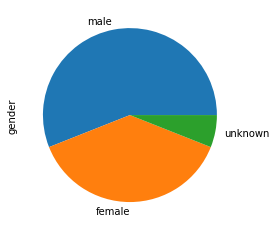

In [11]:
patients_df['gender'].value_counts().plot.pie()

<AxesSubplot:ylabel='race'>

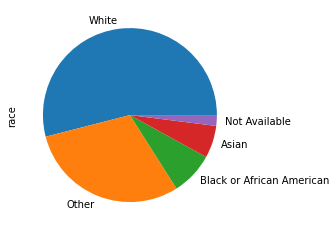

In [12]:
patients_df['race'].value_counts().plot.pie()

<AxesSubplot:ylabel='ethnicity'>

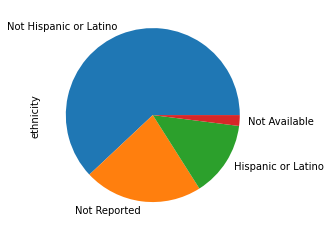

In [13]:
patients_df['ethnicity'].value_counts().plot.pie()

### 1.3. Patients within a given Research Study

The Kids First portal is comprised of multiple research studies. 
See more at:  
  https://portal.kidsfirstdrc.org/studies  
or  
  https://www.notion.so/Studies-and-Access-a5d2f55a8b40461eac5bf32d9483e90f  

In this step we'll explore how to query for patients specifically associated to one of these research studies. Let's pick the "Pediatric Brain Tumor Atlas: CBTTC" as an example, because it has a large number of participants.

First let's find the study we are interested in as a ResearchStudy. There are a few possible ways we can do this, for example a search on ResearchStudy.title, but we don't necessarily know the title of the FHIR resource is going to match those other lists.

Let's list all the ResearchStudies on the server and see what we can find.

In [14]:
r = s.get(f"{FHIR_SERVER}/ResearchStudy")
bundle = r.json()
print_bundle(bundle)

{
  "resourceType": "Bundle",
  "id": "1ab0c40c-1ae9-4379-bab0-6c5919a2ddc5",
  "meta": {
    "lastUpdated": "2022-01-27T18:57:32.243+00:00"
  },
  "type": "searchset",
  "total": 29,
  "link": [
    {
      "relation": "self",
      "url": "https://kf-api-fhir-service.kidsfirstdrc.org/ResearchStudy"
    }
  ],
  "entry": [
    {
      "fullUrl": "https://kf-api-fhir-service.kidsfirstdrc.org/ResearchStudy/276195",
      "resource": {
        "resourceType": "ResearchStudy",
        "id": "276195",
...
Bundle truncated. Change the "print_bundle" function above to print the full content.


Looks like we want ID **76758**, which actually has title "Pediatric Brain Tumor Atlas - Children's Brain Tumor Tissue Consortium". We'll continue to use this ResearchStudy for future steps in this exercise.

If we'd like we can query for ResearchSubjects by this ResearchStudy, and see what an example looks like:

In [15]:
r = s.get(f"{FHIR_SERVER}/ResearchSubject?study=76758")
bundle = r.json()
pprint(bundle['entry'][0])

{'fullUrl': 'https://kf-api-fhir-service.kidsfirstdrc.org/ResearchSubject/81097',
 'resource': {'id': '81097',
              'identifier': [{'system': 'https://kf-api-dataservice.kidsfirstdrc.org/participants/',
                              'value': 'PT_Z4GS3ZQQ'},
                             {'system': 'urn:kids-first:unique-string',
                              'value': 'ResearchSubject-SD_BHJXBDQK-PT_Z4GS3ZQQ'}],
              'individual': {'reference': 'Patient/76747'},
              'meta': {'lastUpdated': '2021-10-14T20:55:21.860+00:00',
                       'profile': ['http://hl7.org/fhir/StructureDefinition/ResearchSubject'],
                       'source': '#PIF3ir4zjspJurfK',
                       'versionId': '1'},
              'resourceType': 'ResearchSubject',
              'status': 'off-study',
              'study': {'reference': 'ResearchStudy/76758'}},
 'search': {'mode': 'match'}}


More importantly, we can query for Patient resources by ResearchStudy via those ResearchSubjects (notice the reference to a Patient in the `individual` field), and again run our same analysis. (hint: sounds like reverse-chaining again!)


🖐 Fill in the query to find Patients that are associated to a ResearchStudy

Then we'll run through our usual mappings and graphs one more time.

In [16]:
r = s.get(f"{FHIR_SERVER}/Patient?_has:ResearchSubject:individual:study=76758")
bundle = r.json()
patients = list(map(lambda e: e['resource'], bundle['entry']))
patients_df = pd.DataFrame(patients)

patients_df['race'] = patients_df['extension'].map(lambda e: get_race(e))
patients_df['ethnicity'] = patients_df['extension'].map(lambda e: get_ethnicity(e))

patients_df.head()

,resourceType,id,meta,extension,identifier,gender,race,ethnicity
0,Patient,76747,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,female,Other,Hispanic or Latino
1,Patient,76722,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,male,White,Not Hispanic or Latino
2,Patient,76718,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,female,White,Not Hispanic or Latino
3,Patient,76744,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,female,White,Not Hispanic or Latino
4,Patient,76732,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,female,White,Not Hispanic or Latino


<AxesSubplot:ylabel='gender'>

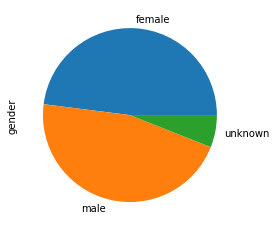

In [17]:
patients_df['gender'].value_counts().plot.pie()

<AxesSubplot:ylabel='race'>

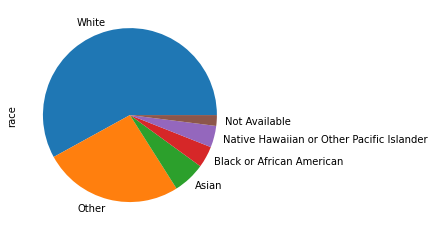

In [18]:
patients_df['race'].value_counts().plot.pie()

<AxesSubplot:ylabel='ethnicity'>

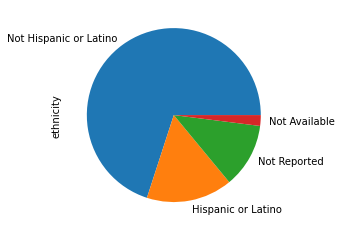

In [19]:
patients_df['ethnicity'].value_counts().plot.pie()

## 2. Most Frequent Diagnoses

Our second step will be show how to perform queries that enable basic prevalence analysis. Again there are a few different ways we can build a cohort for this.

### 2.1. Just the first conditions on the server

As before, let's start with the simplest possible approach of just selecting an unfiltered and unsorted set of Condition resources. This time, let's tell the server we want 250 Conditions.   
(Why 250? In this case it's the most the server will return in one response.)

🖐 Fill in the query to select 250 Condition resources from the server

In [20]:
r = s.get(f"{FHIR_SERVER}/Condition?_count=250")
bundle = r.json()
print_bundle(bundle)

{
  "resourceType": "Bundle",
  "id": "28ff5839-0e65-451e-ae8d-77e09a23e3f6",
  "meta": {
    "lastUpdated": "2022-01-27T18:57:33.127+00:00"
  },
  "type": "searchset",
  "link": [
    {
      "relation": "self",
      "url": "https://kf-api-fhir-service.kidsfirstdrc.org/Condition?_count=250"
    },
    {
      "relation": "next",
      "url": "https://kf-api-fhir-service.kidsfirstdrc.org?_getpages=28ff5839-0e65-451e-ae8d-77e09a23e3f6&_getpagesoffset=250&_count=250&_pretty=true&_bundletype=searchset"
    }
  ],
  "entry": [
    {
      "fullUrl": "https://kf-api-fhir-service.kidsfirstdrc.org/Condition/4935",
...
Bundle truncated. Change the "print_bundle" function above to print the full content.


As before when we've looked at a searchset Bundle, there's too much to really process at a glance.

Let's filter the bundle down to just a list of Condition resources, and see what one Condition resource contains.


In [21]:
conditions = list(map(lambda e: e['resource'], bundle['entry']))
pprint(conditions[0])

{'category': [{'coding': [{'code': 'encounter-diagnosis',
                           'display': 'Encounter Diagnosis',
                           'system': 'http://terminology.hl7.org/CodeSystem/condition-category'}],
               'text': 'Health Status'}],
 'clinicalStatus': {'coding': [{'code': 'inactive',
                                'display': 'Inactive',
                                'system': 'http://terminology.hl7.org/CodeSystem/condition-clinical'}],
                    'text': 'No'},
 'code': {'coding': [{'code': 'HP:0012211',
                      'display': 'Abnormal renal physiology',
                      'system': 'http://purl.obolibrary.org/obo/hp.owl'}],
          'text': 'Renal systems dysfunction'},
 'id': '4935',
 'identifier': [{'value': '01456-1-Renal systems dysfunction'}],
 'meta': {'lastUpdated': '2021-10-14T16:01:08.153+00:00',
          'profile': ['http://hl7.org/fhir/StructureDefinition/Condition'],
          'source': '#cDMAiYdumLMIL2zr',
          

The key to what this Condition represents is nested within the `code` field, but there's a lot of information there. Let's dig into three very important types in FHIR: `code`, `Coding`, and `CodeableConcept`.
### code
`code` is a FHIR primitive based on string. `code`s are generally taken from a controlled set of strings defined elsewhere, and are restricted in that `code`s may not contain leading whitespace, trailing whitespace, or more than 1 consecutive whitespace character. `"9283-4"` is an example of a `code`.


### Coding
[`Coding`](https://www.hl7.org/fhir/datatypes.html#Coding) is a general purpose datatype that builds on top of `code`. A `Coding` is a representaton of a defined concept using a symbol from a defined code system. `Coding` includes fields for `code`, the code `system` it comes from, the `version` of the system, a human-readable `display`, and `userSelected` to indicate if this coding was chosen directly by the user. An example `Coding`:

```
{
  "system": "http://snomed.info/sct",
  "code": "444814009",
  "display": "Viral sinusitis (disorder)"
}
```

### CodeableConcept
[`CodeableConcept`](https://www.hl7.org/fhir/datatypes.html#CodeableConcept) is a general purpose datatype builds further on top of `Coding`. A `CodeableConcept` represents a value that is usually supplied by providing a reference to one or more terminologies or ontologies but may also be defined by the provision of text. Most resources that are defined by specific clinical concepts will include a `CodeableConcept` type field.
`CodeableConcept` includes fields for an array of `coding`s and optional `text`.


An example `CodeableConcept`:
```
{
    "coding": [
        {
            "system": "http://snomed.info/sct",
            "code": "260385009",
            "display": "Negative"
        }, {
            "system": "https://acme.lab/resultcodes",
            "code": "NEG",
            "display": "Negative"
        }
    ],
    "text": "Negative for Chlamydia Trachomatis rRNA"
}
```


In this case all we really want is a consistent human-readable display, so let's get these into a DataFrame and map that `code` field into something appropriate.


In [22]:
conditions_df = pd.DataFrame(conditions)
conditions_df.head()

,resourceType,id,meta,identifier,clinicalStatus,verificationStatus,category,code,subject,_onsetDateTime
0,Condition,4935,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Renal systems dysfunction'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN
1,Condition,4943,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Autoimmune disorders'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN
2,Condition,4950,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Acute kidney injury'}],NaN,NaN,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN
3,Condition,4957,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Cardiac failure'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},{'extension': [{'url': 'http://hl7.org/fhir/St...
4,Condition,4965,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Hypertension'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},{'extension': [{'url': 'http://hl7.org/fhir/St...


🖐 Fill in the `get_code` function to pick a human-readable description out of the `code` field.

We'll use this function to define a new `description` column which we'll use to determine which conditions are the most prevalent.

(Hint: the `code` field is a CodeableConcept -- look at the CodeableConcept spec to see what fields are optional and what are required. We'll be using this function throughout the exercise to parse CodeableConcepts.)

In [23]:
def get_code(c):
    if 'coding' in c:
        if display in c['coding'][0]:
            return c['coding'][0]['display']
        elif 'text' in c:
            return c['text']
        else:
            return c['coding'][0]['code']
    
    if 'text' in c:
        return c['text']

    return ''


conditions_df['description'] = conditions_df['code'].map(lambda c: get_code(c))

conditions_df.head()

,resourceType,id,meta,identifier,clinicalStatus,verificationStatus,category,code,subject,_onsetDateTime,description
0,Condition,4935,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Renal systems dysfunction'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN,Renal systems dysfunction
1,Condition,4943,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Autoimmune disorders'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN,Autoimmune disorders
2,Condition,4950,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Acute kidney injury'}],NaN,NaN,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN,Acute kidney injury
3,Condition,4957,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Cardiac failure'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},{'extension': [{'url': 'http://hl7.org/fhir/St...,Cardiac failure
4,Condition,4965,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Hypertension'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},{'extension': [{'url': 'http://hl7.org/fhir/St...,Hypertension


Now let's create a graph of the top 10 most prevalent conditions:

<AxesSubplot:xlabel='count', ylabel='description'>

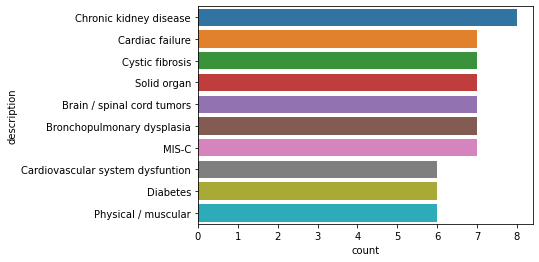

In [24]:
counts = conditions_df.groupby(['description']).count().reset_index()
counts.rename(columns={'resourceType': 'count'}, inplace=True)

counts = counts.sort_values('count', ascending=False).head(10)
sns.barplot(data=counts, x='count', y='description')

### 2.2. Patients in the Research Study

In the previous steps, we looked at just a random sampling of Conditions: the first 250 that the server happened to return. Now let's return to the Research Study and see how we can query for just those Conditions.


One might expect we can just chain even further, for example:
```
/Condition?subject._has:ResearchSubject:individual:study=76758
```
However, that's not going to work here. (it seems to hang the entire server for about 2 minutes so we request you not to actually run it)


Instead, let's combine two search concepts:
 - get the Patients by ResearchStudy, as we saw before ("reverse chaining")
 - include the Conditions that reference back to each Patient


We've seen how to find a resource, based on another resource that references it, but we haven't yet seen how to include multiple resource types in a single search. This leads us to new search parameters we haven't seen before: `_include` and `_revinclude`. 

`_include` allows for including resources that the queried resource references out to. (For example, Condition references out to a Patient and Encounter)  
`_revinclude` ie, "reverse include", allows for including resources that reference back to the queried resource. (For example, Patient is referenced by Condition)  

These parameters specify a search parameter to search on, which includes 3 parts:
 - The name of the source resource where the reference field exists
 - The field name of the reference
 - (optionally) a specific type of target resource, for cases when multiple resource types are allowed.
 

Some simple examples:

```
GET [base]/MedicationRequest?_include=MedicationRequest:patient
GET [base]/MedicationRequest?_revinclude=Provenance:target
```

The first search requests all matching MedicationRequests, to include any patient that the medication prescriptions in the result set refer to. The second search requests all matching prescriptions, return all the provenance resources that refer to them. 


📘[Read more about including other resources in search results](https://www.hl7.org/fhir/search.html#include)


🖐 Implement the query to select Patients within the ResearchStudy of interest and include their Conditions

Reminder: the ResearchStudy id = **76758**

In [25]:
r = s.get(f"{FHIR_SERVER}/Patient?_has:ResearchSubject:individual:study=76758&_revinclude=Condition:subject")
bundle = r.json()
print_bundle(bundle)

{
  "resourceType": "Bundle",
  "id": "f52bd4d1-d18c-4b20-aedc-e7f7762739a7",
  "meta": {
    "lastUpdated": "2022-01-27T18:57:34.231+00:00"
  },
  "type": "searchset",
  "link": [
    {
      "relation": "self",
      "url": "https://kf-api-fhir-service.kidsfirstdrc.org/Patient?_has%3AResearchSubject%3Aindividual%3Astudy=76758&_revinclude=Condition%3Asubject"
    },
    {
      "relation": "next",
      "url": "https://kf-api-fhir-service.kidsfirstdrc.org?_getpages=f52bd4d1-d18c-4b20-aedc-e7f7762739a7&_getpagesoffset=50&_count=50&_pretty=true&_include=Condition%3Asubject&_bundletype=searchset"
    }
  ],
  "entry": [
    {
      "fullUrl": "https://kf-api-fhir-service.kidsfirstdrc.org/Patient/76747",
...
Bundle truncated. Change the "print_bundle" function above to print the full content.


So this time we have 2 different resourceTypes in our results. Patients at the top of the Bundle and Conditions at the bottom. We don't actually need the Patient resources for this analysis, so let's filter to just the Conditions and re-use our functions from the previous step:

<AxesSubplot:xlabel='count', ylabel='description'>

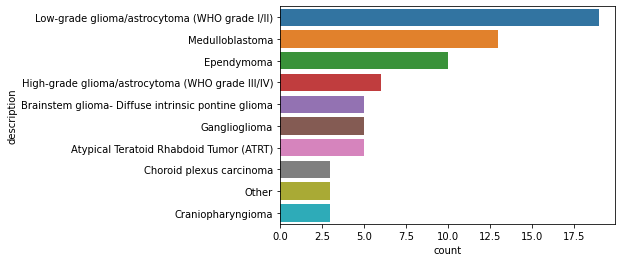

In [26]:
all_resources = list(map(lambda e: e['resource'], bundle['entry']))
conditions = list(filter(lambda r: r['resourceType'] == 'Condition', all_resources))
conditions_df = pd.DataFrame(conditions)
conditions_df['description'] = conditions_df['code'].map(lambda c: get_code(c))
counts = conditions_df.groupby(['description']).count().reset_index()
counts.rename(columns={'resourceType': 'count'}, inplace=True)

counts = counts.sort_values('count', ascending=False).head(10)
sns.barplot(data=counts, x='count', y='description')

Now we have a more useful graph - the most common diagnoses among a research study cohort. (Note however that this represents only the first page of results from the server, not necessarily the entire cohort. Pagination, as seen in the previous exercise, may be necessary to fetch the entire cohort.)

## 3. Age at Diagnosis

Our third step will be to see how we can recreate the Age at Diagnosis chart.

To calculate age at diagnosis, we need two pieces of information:
 - Date of Birth
 - Date of Diagnosis  

However in order to de-identify the data, Kids First has removed date of birth information from Patient resources. Instead they use relative dates via an extension.

In FHIR these may be captured in different resources that we may need to cross-reference:

- `Patient.birthDate`
- `Condition.onset[x]`
- `Condition.recordedDate`

Let's take a look at how the Kids First server represents these important concepts

### 3.1. Diagnoses of a particular Condition

Let's start by querying for Conditions of a given code. We'll stick with **MONDO:0021640** (grade III glioma) as our condition of interest.

🖐 Fill in the query to select Conditions by this code

Then we'll look at one instance to see what it contains.

In [27]:
r = s.get(f"{FHIR_SERVER}/Condition?code=MONDO:0021640")
bundle = r.json()
pprint(bundle['entry'][0]['resource'])

{'_recordedDate': {'extension': [{'extension': [{'url': 'event',
                                                 'valueCodeableConcept': {'coding': [{'code': '3950001',
                                                                                      'display': 'Birth',
                                                                                      'system': 'http://snomed.info/sct'}]}},
                                                {'url': 'relationship',
                                                 'valueCode': 'after'},
                                                {'url': 'offset',
                                                 'valueDuration': {'code': 'd',
                                                                   'system': 'http://unitsofmeasure.org',
                                                                   'unit': 'days',
                                                                   'value': 7805}}],
                                  

What we see here is that the Condition has a `_recordedDate` field with an extension "http://hl7.org/fhir/StructureDefinition/relative-date", then nested below that are 3 sub-extensions representing the parts of a "relative date": 
 - The event that this Condition is relative to
 - The relationship (before/after)
 - The numerical offset
 
See more about the relative-date extension here: http://hl7.org/fhir/R4/extension-relative-date.html
 
 
Now let's put this into a DataFrame:

In [28]:
conditions = list(map(lambda e: e['resource'], bundle['entry']))
conditions_df = pd.DataFrame(conditions)

And let's extract that into a single number that we can use for analysis.

🖐 Write a function to parse the age of onset in days, out of the recordedDate extension.

(Note: for data aggregated from multiple sources, you may encounter data in very different forms. For the dataset we are working with in this step, we can safely assume that all recordedDate extensions will be of this form if present: relative to birth, after birth, and recorded in days.)

We'll use this function to map the condition into a new column for onset age in years. 

In [29]:
def get_age_of_onset(recordedDate):
    return recordedDate['extension'][0]['extension'][2]['valueDuration']['value']

conditions_df['onsetAgeInYears'] = conditions_df['_recordedDate'].map(lambda c: get_age_of_onset(c) // 365)

conditions_df.head()

,resourceType,id,meta,identifier,clinicalStatus,verificationStatus,category,code,bodySite,subject,_recordedDate,onsetAgeInYears
0,Condition,81140,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Brain Stem- Midbrain/Tectum;Cerebel...,{'reference': 'Patient/72411'},{'extension': [{'url': 'http://hl7.org/fhir/St...,21
1,Condition,81159,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Frontal Lobe;Temporal Lobe'}],{'reference': 'Patient/72432'},{'extension': [{'url': 'http://hl7.org/fhir/St...,17
2,Condition,81126,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Not Reported'}],{'reference': 'Patient/72411'},{'extension': [{'url': 'http://hl7.org/fhir/St...,21
3,Condition,81118,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Frontal Lobe'}],{'reference': 'Patient/72406'},{'extension': [{'url': 'http://hl7.org/fhir/St...,18
4,Condition,81164,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Brain Stem- Pons'}],{'reference': 'Patient/72428'},{'extension': [{'url': 'http://hl7.org/fhir/St...,6


Now let's graph the ages with a basic histogram:

<AxesSubplot:xlabel='onsetAgeInYears', ylabel='Count'>

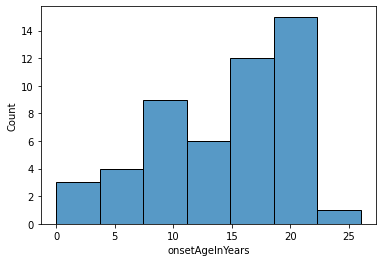

In [30]:
sns.histplot(data=conditions_df, x='onsetAgeInYears')

### 3.2. Patients in the Research Study

Now let's go back to our selected Research Study and see how we can get the Conditions for those Patients in the study. We've seen before that doubly-nested references may not work, so instead we can combine multiple approaches as we saw in section 2.2, to fetch Patients by ResearchStudy, and then include their diagnosed Conditions.


🖐 Fill in the query to select Patients in the ResearchStudy of interest, along with their Conditions.

Reminder: the ResearchStudy id = **76758**

In [31]:
r = s.get(f"{FHIR_SERVER}/Patient?_has:ResearchSubject:individual:study=76758&_revinclude=Condition:subject")
bundle = r.json()
print_bundle(bundle)

{
  "resourceType": "Bundle",
  "id": "f52bd4d1-d18c-4b20-aedc-e7f7762739a7",
  "meta": {
    "lastUpdated": "2022-01-27T18:57:34.231+00:00"
  },
  "type": "searchset",
  "link": [
    {
      "relation": "self",
      "url": "https://kf-api-fhir-service.kidsfirstdrc.org/Patient?_has%3AResearchSubject%3Aindividual%3Astudy=76758&_revinclude=Condition%3Asubject"
    },
    {
      "relation": "next",
      "url": "https://kf-api-fhir-service.kidsfirstdrc.org?_getpages=f52bd4d1-d18c-4b20-aedc-e7f7762739a7&_getpagesoffset=50&_count=50&_pretty=true&_include=Condition%3Asubject&_bundletype=searchset"
    }
  ],
  "entry": [
    {
      "fullUrl": "https://kf-api-fhir-service.kidsfirstdrc.org/Patient/76747",
...
Bundle truncated. Change the "print_bundle" function above to print the full content.


Now we can see in this Bundle we have both Patients and Conditions. We don't strictly need the Patient resources so let's filter down to just Conditions.

In [32]:
all_resources = list(map(lambda e: e['resource'], bundle['entry']))
conditions = list(filter(lambda r: r['resourceType'] == 'Condition', all_resources))
conditions_df = pd.DataFrame(conditions)
conditions_df.head()

,resourceType,id,meta,identifier,clinicalStatus,verificationStatus,category,code,bodySite,subject,_recordedDate
0,Condition,89473,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Brain Stem- Pons'}],{'reference': 'Patient/76698'},{'extension': [{'url': 'http://hl7.org/fhir/St...
1,Condition,89472,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Optic Pathway'}],{'reference': 'Patient/76701'},{'extension': [{'url': 'http://hl7.org/fhir/St...
2,Condition,89475,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Brain Stem- Pons'}],{'reference': 'Patient/76704'},{'extension': [{'url': 'http://hl7.org/fhir/St...
3,Condition,89474,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Brain Stem- Pons'}],{'reference': 'Patient/76704'},{'extension': [{'url': 'http://hl7.org/fhir/St...
4,Condition,89477,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Brain Stem- Pons'}],{'reference': 'Patient/76704'},{'extension': [{'url': 'http://hl7.org/fhir/St...


What we may notice though is that not all of these Conditions contain a recordedDate, so for this step we'll filter to only those that do.

In [33]:
conditions_df.dropna(subset=['_recordedDate'], inplace=True)
conditions_df.head()

,resourceType,id,meta,identifier,clinicalStatus,verificationStatus,category,code,bodySite,subject,_recordedDate
0,Condition,89473,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Brain Stem- Pons'}],{'reference': 'Patient/76698'},{'extension': [{'url': 'http://hl7.org/fhir/St...
1,Condition,89472,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Optic Pathway'}],{'reference': 'Patient/76701'},{'extension': [{'url': 'http://hl7.org/fhir/St...
2,Condition,89475,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Brain Stem- Pons'}],{'reference': 'Patient/76704'},{'extension': [{'url': 'http://hl7.org/fhir/St...
3,Condition,89474,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Brain Stem- Pons'}],{'reference': 'Patient/76704'},{'extension': [{'url': 'http://hl7.org/fhir/St...
4,Condition,89477,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Brain Stem- Pons'}],{'reference': 'Patient/76704'},{'extension': [{'url': 'http://hl7.org/fhir/St...


And then we can run the same steps as previously to convert the column, and graph the results.

<AxesSubplot:xlabel='onsetAgeInYears', ylabel='Count'>

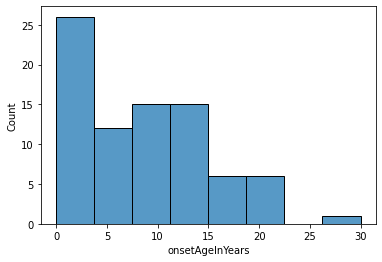

In [34]:
conditions_df['onsetAgeInYears'] = conditions_df['_recordedDate'].map(lambda c: get_age_of_onset(c) // 365)
sns.histplot(data=conditions_df, x='onsetAgeInYears')

## 4. Overall Survival

### 4.1. Patients in the Research Study

Our final step in this exercise will be to reproduce the Overall Survival graph. The data requirements for this graph build on top of the previous steps, so now we need to know the relationship between date of death, or last recorded survival, and date of onset.

As before, Kids First data has been deidentified so there generally are no absolute dates, but relative dates are enough as long as there is a common reference point. Fortunately most of KF uses dates relative to birth or enrollment into a clinical trial.

First let's see how KF reports death information. One possibility is in the `Patient.deceased[x]` field, so let's see if anything on the server has that populated.

In [35]:
r = s.get(f"{FHIR_SERVER}/Patient?deceased=true")
bundle = r.json()
print_bundle(bundle)

{'resourceType': 'Bundle',
 'id': '51ce9339-b4f9-4a72-8305-a2b5ca55911c',
 'meta': {'lastUpdated': '2022-01-27T18:57:36.191+00:00'},
 'type': 'searchset',
 'total': 0,
 'link': [{'relation': 'self',
   'url': 'https://kf-api-fhir-service.kidsfirstdrc.org/Patient?deceased=true'}]}

Looks like that's a no. That's fine, there are other options. We'll spare the reader the full exploration process, but we know that in this case, Clinical Status of "Alive" or "Dead" is captured as an Observation with SNOMED code "263493007". Observations can be thought of as a clinical question of sorts, where the question is captured as the `code` and the answer is captured as the `value`.

📘 [Read more about the Observation resource](https://www.hl7.org/fhir/observation.html)


Let's look at an example of one of these:

In [36]:
r = s.get(f"{FHIR_SERVER}/Observation?code=263493007&_count=1")
bundle = r.json()
print_bundle(bundle)

{
  "resourceType": "Bundle",
  "id": "ed9b175e-e181-44d0-ad64-440dd9aaa5c0",
  "meta": {
    "lastUpdated": "2022-01-27T18:57:36.237+00:00"
  },
  "type": "searchset",
  "link": [
    {
      "relation": "self",
      "url": "https://kf-api-fhir-service.kidsfirstdrc.org/Observation?_count=1&code=263493007"
    },
    {
      "relation": "next",
      "url": "https://kf-api-fhir-service.kidsfirstdrc.org?_getpages=ed9b175e-e181-44d0-ad64-440dd9aaa5c0&_getpagesoffset=1&_count=1&_pretty=true&_bundletype=searchset"
    }
  ],
  "entry": [
    {
      "fullUrl": "https://kf-api-fhir-service.kidsfirstdrc.org/Observation/22368",
...
Bundle truncated. Change the "print_bundle" function above to print the full content.


Like with the Condition resources in previous examples, we see an `_effectiveDate` with extensions describing a date relative to birth. There's our common reference point, so let's gather all our data and put it together.

In this case, we want Patients, Conditions, and Observations. There are multiple possible approaches we could take here. One possible approach is to make 1 query to find Patients, 1 query to find all Conditions, then 1 query to find all Observations, then join the results and drop any mismatches. In this case let's see if we can do it in one single query.


🖐 Fill in the query to fetch Patients, Conditions, and Observations, for Patients in our ResearchStudy of interest.

Reminder: the ResearchStudy id = **76758**

In [37]:
r = s.get(f"{FHIR_SERVER}/Patient?_has:ResearchSubject:individual:study=76758&_revinclude=Condition:subject&_revinclude=Observation:subject")
bundle = r.json()
print_bundle(bundle)

{
  "resourceType": "Bundle",
  "id": "18995bc4-2586-4b0a-bc97-eadf5c7f6b61",
  "meta": {
    "lastUpdated": "2022-01-27T18:57:36.293+00:00"
  },
  "type": "searchset",
  "link": [
    {
      "relation": "self",
      "url": "https://kf-api-fhir-service.kidsfirstdrc.org/Patient?_has%3AResearchSubject%3Aindividual%3Astudy=76758&_revinclude=Condition%3Asubject&_revinclude=Observation%3Asubject"
    },
    {
      "relation": "next",
      "url": "https://kf-api-fhir-service.kidsfirstdrc.org?_getpages=18995bc4-2586-4b0a-bc97-eadf5c7f6b61&_getpagesoffset=50&_count=50&_pretty=true&_include=Observation%3Asubject&_include=Condition%3Asubject&_bundletype=searchset"
    }
  ],
  "entry": [
    {
      "fullUrl": "https://kf-api-fhir-service.kidsfirstdrc.org/Patient/76747",
...
Bundle truncated. Change the "print_bundle" function above to print the full content.


Note that this query we just ran selected ALL Conditions and Observations linked to the selected Patients. If we need to filter the results further, we can only do that by post-processing and not within the FHIR query itself.
Fortunately there only appears to be one Observation per Patient in this dataset, so there is no need to filter further.


Let's break this Bundle out into separate lists for the 3 resourceTypes, and then turn them into DataFrames.

We'll inspect the Observations DataFrame first because this is the first time we're seeing Observations.

In [38]:
all_resources = list(map(lambda e: e['resource'], bundle['entry']))
patients = list(filter(lambda r: r['resourceType'] == 'Patient', all_resources))
conditions = list(filter(lambda r: r['resourceType'] == 'Condition', all_resources))
observations = list(filter(lambda r: r['resourceType'] == 'Observation', all_resources))

patients_df = pd.DataFrame(patients)
conditions_df = pd.DataFrame(conditions)
observations_df = pd.DataFrame(observations)

observations_df.head()

,resourceType,id,meta,identifier,status,code,subject,_effectiveDateTime,valueCodeableConcept
0,Observation,94597,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76695'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...
1,Observation,94596,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76706'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...
2,Observation,94601,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76703'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...
3,Observation,94603,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76702'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...
4,Observation,94605,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76683'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...


To calculate survival, we have to get subtract onset date from the latest clinical status date (Observation).
As with Condition `_recordedDate`, these Observations use a relative date via an extension on `_effectiveDateTime`.

Let's break that out into a single number. Fortunately the format is exactly the same as before, so we can reuse the same function we defined earlier.

In [39]:
observations_df.dropna(subset=['_effectiveDateTime'], inplace=True)
observations_df['effectiveAgeDays'] = observations_df['_effectiveDateTime'].map(lambda c: get_age_of_onset(c))

observations_df.head()

,resourceType,id,meta,identifier,status,code,subject,_effectiveDateTime,valueCodeableConcept,effectiveAgeDays
0,Observation,94597,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76695'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,2522
1,Observation,94596,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76706'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,7182
2,Observation,94601,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76703'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,3007
3,Observation,94603,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76702'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,144
4,Observation,94605,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76683'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,1374


Then do the same to Conditions, again in the `_recordedDate` field


In [40]:
conditions_df.dropna(subset=['_recordedDate'], inplace=True)
conditions_df['onsetAgeDays'] = conditions_df['_recordedDate'].map(lambda c: get_age_of_onset(c))

conditions_df.head()

,resourceType,id,meta,identifier,verificationStatus,code,subject,clinicalStatus,category,bodySite,_recordedDate,onsetAgeDays
3,Condition,89441,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76681'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Cerebellum/Posterior Fossa;Other lo...,{'extension': [{'url': 'http://hl7.org/fhir/St...,3827
4,Condition,89440,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76683'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Ventricles'}],{'extension': [{'url': 'http://hl7.org/fhir/St...,378
5,Condition,89443,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76681'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Cerebellum/Posterior Fossa'}],{'extension': [{'url': 'http://hl7.org/fhir/St...,4117
7,Condition,89445,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76681'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Cerebellum/Posterior Fossa'}],{'extension': [{'url': 'http://hl7.org/fhir/St...,3270
8,Condition,89446,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76695'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Frontal Lobe'}],{'extension': [{'url': 'http://hl7.org/fhir/St...,2522


We're going to have to join these two together, so let's clean the patient ID references to be strings rather than dicts.

From:
```
reference: { reference: "Patient/1234" }
```

To:
```
reference: 1234
```

In [41]:
def reference_to_id(reference):
    reference = reference['reference']
    if '/' in reference:
        idx = reference.index('/')
        return reference[idx+1:]
    else:
        return reference

In [42]:
conditions_df['patientId'] = conditions_df['subject'].map(reference_to_id)
conditions_df.head()

,resourceType,id,meta,identifier,verificationStatus,code,subject,clinicalStatus,category,bodySite,_recordedDate,onsetAgeDays,patientId
3,Condition,89441,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76681'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Cerebellum/Posterior Fossa;Other lo...,{'extension': [{'url': 'http://hl7.org/fhir/St...,3827,76681
4,Condition,89440,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76683'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Ventricles'}],{'extension': [{'url': 'http://hl7.org/fhir/St...,378,76683
5,Condition,89443,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76681'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Cerebellum/Posterior Fossa'}],{'extension': [{'url': 'http://hl7.org/fhir/St...,4117,76681
7,Condition,89445,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76681'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Cerebellum/Posterior Fossa'}],{'extension': [{'url': 'http://hl7.org/fhir/St...,3270,76681
8,Condition,89446,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76695'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Frontal Lobe'}],{'extension': [{'url': 'http://hl7.org/fhir/St...,2522,76695


In [43]:
observations_df['patientId'] = observations_df['subject'].map(reference_to_id)
observations_df.head()

,resourceType,id,meta,identifier,status,code,subject,_effectiveDateTime,valueCodeableConcept,effectiveAgeDays,patientId
0,Observation,94597,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76695'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,2522,76695
1,Observation,94596,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76706'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,7182,76706
2,Observation,94601,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76703'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,3007,76703
3,Observation,94603,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76702'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,144,76702
4,Observation,94605,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76683'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,1374,76683


Now let's join the observations and conditions together on patient ID

In [44]:
obs_conds_df = conditions_df.join(observations_df.set_index('patientId'), on='patientId', lsuffix='_c', rsuffix='_o')

obs_conds_df.head()

,resourceType_c,id_c,meta_c,identifier_c,verificationStatus,code_c,subject_c,clinicalStatus,category,bodySite,...,resourceType_o,id_o,meta_o,identifier_o,status,code_o,subject_o,_effectiveDateTime,valueCodeableConcept,effectiveAgeDays
3,Condition,89441,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76681'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Cerebellum/Posterior Fossa;Other lo...,...,Observation,94609,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76681'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,4230
4,Condition,89440,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76683'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Ventricles'}],...,Observation,94605,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76683'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,1374
5,Condition,89443,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76681'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Cerebellum/Posterior Fossa'}],...,Observation,94609,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76681'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,4230
7,Condition,89445,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76681'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Cerebellum/Posterior Fossa'}],...,Observation,94609,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76681'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,4230
8,Condition,89446,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76695'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Frontal Lobe'}],...,Observation,94597,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76695'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,2522


Now we have 2 columns representing the age of condition onset from birth in days, and the age of last recorded survival. We can calculate length of survival as the difference of these 2 columns.

In [45]:
obs_conds_df['survivalDays'] = obs_conds_df['effectiveAgeDays'] - obs_conds_df['onsetAgeDays']

obs_conds_df.head()


,resourceType_c,id_c,meta_c,identifier_c,verificationStatus,code_c,subject_c,clinicalStatus,category,bodySite,...,id_o,meta_o,identifier_o,status,code_o,subject_o,_effectiveDateTime,valueCodeableConcept,effectiveAgeDays,survivalDays
3,Condition,89441,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76681'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Cerebellum/Posterior Fossa;Other lo...,...,94609,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76681'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,4230,403
4,Condition,89440,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76683'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Ventricles'}],...,94605,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76683'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,1374,996
5,Condition,89443,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76681'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Cerebellum/Posterior Fossa'}],...,94609,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76681'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,4230,113
7,Condition,89445,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76681'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Cerebellum/Posterior Fossa'}],...,94609,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76681'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,4230,960
8,Condition,89446,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/76695'},{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,[{'text': 'Frontal Lobe'}],...,94597,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,final,{'coding': [{'system': 'http://snomed.info/sct...,{'reference': 'Patient/76695'},{'extension': [{'url': 'http://hl7.org/fhir/St...,{'coding': [{'system': 'http://snomed.info/sct...,2522,0


Finally we can calculate the % survival at each duration to graph the survival rate over time. (There may be better ways to do this, but hopefully this code is fairly clear as to the intent)

<AxesSubplot:xlabel='days', ylabel='survivalRate'>

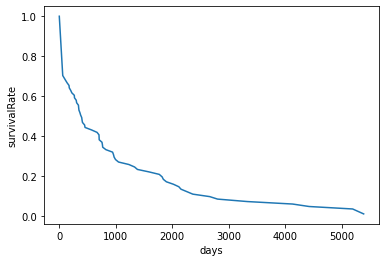

In [46]:
durations = obs_conds_df.sort_values('survivalDays')['survivalDays'].unique()

total = len(obs_conds_df)

survival_df = pd.DataFrame(columns=['days','survivalRate'], dtype=np.number)

for day in durations:
    num_surviving_at_day = (obs_conds_df['survivalDays'] >= day).sum()
    survival_rate = num_surviving_at_day / total
    survival_df = survival_df.append({'days': day, 'survivalRate': survival_rate}, ignore_index=True)

sns.lineplot(data=survival_df, x='days', y='survivalRate')

## Summary

Well done! We've just walked through eight different sample queries to build out content for four fundamental concepts. 
